In [1]:
# two

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 200,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = l1_regularizer))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 50
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint

    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    

C:\Users\tcumi\Anaconda3\envs\py_3_6\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\tcumi\github_repo\neural-network\python\ga.py:201: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)
C:\Users\tcumi\Anaconda3\envs\py_3_6\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=Fal

Checkpoint 50, Accuracy: 0.9320987654320988, Loss: 0.3308235097814489
Checkpoint 100, Accuracy: 0.9382716049382716, Loss: 0.30134045636212387
Checkpoint 150, Accuracy: 0.9506172839506173, Loss: 0.28067359217890986
Checkpoint 200, Accuracy: 0.9506172839506173, Loss: 0.2557623651292589
Checkpoint 250, Accuracy: 0.9567901234567902, Loss: 0.24341625637478298
Checkpoint 300, Accuracy: 0.9629629629629629, Loss: 0.24769777721828884
Checkpoint 350, Accuracy: 0.9629629629629629, Loss: 0.2277536392211914
Checkpoint 400, Accuracy: 0.9629629629629629, Loss: 0.22269736395941842
Checkpoint 450, Accuracy: 0.9629629629629629, Loss: 0.20837773217095268
Checkpoint 500, Accuracy: 0.9629629629629629, Loss: 0.20365517227737992


In [10]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.91887367 0.03921871 0.04190755]
[1. 0. 0.] <-> [0.94555837 0.01708156 0.03736007]
[1. 0. 0.] <-> [0.73864585 0.20394354 0.05741056]
[0. 1. 0.] <-> [0.06857797 0.926878   0.00454407]
[1. 0. 0.] <-> [0.9436258  0.02376879 0.03260539]
[0. 1. 0.] <-> [0.07338426 0.9203622  0.00625357]
[1. 0. 0.] <-> [0.8773096  0.03921953 0.0834709 ]
[1. 0. 0.] <-> [0.932689   0.01524622 0.05206469]
[1. 0. 0.] <-> [0.9389666  0.03033252 0.03070086]
[1. 0. 0.] <-> [0.9582516  0.01549063 0.02625784]
[1. 0. 0.] <-> [0.5193839  0.44009802 0.04051811]
[1. 0. 0.] <-> [0.9251044  0.04061221 0.03428344]
[0. 1. 0.] <-> [0.08581711 0.9053153  0.00886767]
[1. 0. 0.] <-> [0.84408754 0.01084401 0.14506844]
[1. 0. 0.] <-> [0.92514896 0.01443098 0.06042001]
[1. 0. 0.] <-> [0.8881989  0.08252245 0.02927868]
[0. 0. 1.] <-> [0.2773991  0.00748055 0.7151204 ]
[0. 0. 1.] <-> [0.12949713 0.00535226 0.8651506 ]
[0. 0. 1.] <-> [0.08214181 0.00380395 0.9140542 ]
[1. 0. 0.] <-> [0.7542989  0.22231965 0.02338139]


In [12]:
# Testing Performance

C:\Users\tcumi\Anaconda3\envs\py_3_6\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


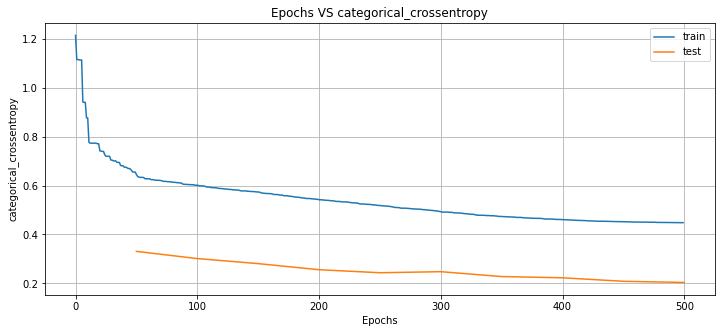

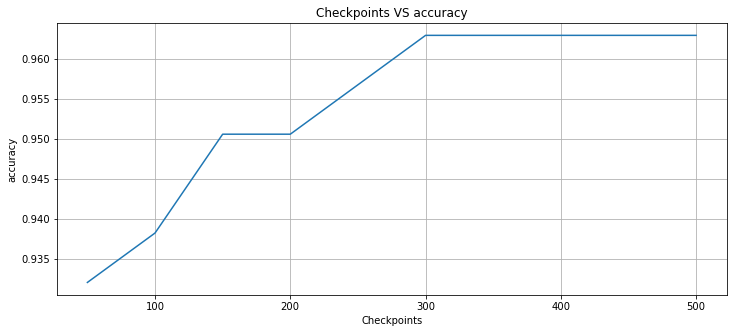

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9320987654320988, 'mean_square_error': 0.17704642387659353, 'categorical_crossentropy': 0.3308235097814489, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 10, 'tn_hit': 20, 'fn_hit': 1}, 1: {'tp_hit': 11, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 5}, 2: {'tp_hit': 9, 'fp_hit': 1, 'tn_hit': 93, 'fn_hit': 5}}, 'checkpoint': 50} 


{'accuracy': 0.9382716049382716, 'mean_square_error': 0.15800001094798788, 'categorical_crossentropy': 0.30134045636212387, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 9, 'tn_hit': 21, 'fn_hit': 1}, 1: {'tp_hit': 11, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 5}, 2: {'tp_hit': 10, 'fp_hit': 1, 'tn_hit': 93, 'fn_hit': 4}}, 'checkpoint': 100} 


{'accuracy': 0.9506172839506173, 'mean_square_error': 0.14657996481892707, 'categorical_crossentropy': 0.28067359217890986, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 8, 'tn_hit': 22, 'fn_hit': 0}, 1: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 4}, 2: {'tp_hit': 10, 'fp_hit': 0, 'tn_hit': 94, '

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[ 0.03264892 -1.2976109   0.00464506  0.8326889   1.3689207 ]
 bias: -1.2957756519317627

Neuron 1: weights:
[-0.04061566  0.5016197   0.00399102 -0.15919879 -0.5177931 ]
 bias: -0.004159554839134216

Neuron 2: weights:
[-0.19351894  1.3848852   0.00677119  0.00662245 -0.01331663]
 bias: 0.03854746371507645

Neuron 3: weights:
[ 1.2078737  -1.6793412  -1.8393499   0.00832738 -0.00383512]
 bias: 1.1870375871658325

$
Layer 2
Neuron 0: weights:
[-2.6817193e+00  4.7956011e-03 -8.9114177e-04  3.0000000e+00]
 bias: -0.0051224310882389545

Neuron 1: weights:
[ 0.00573507  0.02106021  2.556227   -3.        ]
 bias: 0.03757450357079506

Neuron 2: weights:
[ 3.         -1.9523215  -1.0054486   0.00668208]
 bias: 0.006879132241010666

$

